# Training an LSTM network on the Penn Tree Bank (PTB) dataset
---

## Introduction

Long Short-Term Memory (LSTM) networks were first proposed by Sepp Hochreiter and [Jürgen Schmidhuber][1] in 1997 for modeling sequence data. [Christopher Olah][2] has nicely illustrated how they work. The fifth course in the [deep learning specialization on Coursera][3] teaches recurrent neural networks (RNN), of which the LSTM is a variant, in detail, and explains many interesting applications. For a succinct summary of the mathematics of these models, see, for example, [Stanford cs231n lecture 10][4] or [Greff, et al. (2016)][5].

Here, an object-oriented design of a non-regularized LSTM network is implemented in Python/Numpy, trained on the [Penn Tree Bank (PTB) dataset][7], and used to replicate previously published work. The present implementation is shown to replicate word-level perplexities previously reported. 


[1]: http://people.idsia.ch/~juergen/
[2]: http://colah.github.io/posts/2015-08-Understanding-LSTMs/
[3]: https://www.coursera.org/specializations/deep-learning
[4]: http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture10.pdf
[5]: https://arxiv.org/abs/1503.04069
[6]: https://gist.github.com/karpathy/d4dee566867f8291f086
[7]: http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz


---

## An object-oriented implementation of an LSTM network in Python/Numpy

This is a minimalist implementation of an LSTM network, partly inspired by [Karpathy's minimalist character-level language model][6]. There is no GPU acceleration built in. There are four main classes:

1. Lstm
2. Weight
3. Network
4. Embedding

Instances of Lstm can be strung together to form a multi-layer recurrent neural network unrolled to any specified length. Each layer of the network has an associated instance of Weight for maintaining/updating weights and biases. All Lstm instances belonging to the same layer reference the same Weight instance. The Network class will handle this stringing together of Lstm instances, and an instance of Network represents a fully configured network. There is an Embedding class which encapsulates word embeddings, which are trainable dense limited-length vector representations of the vocabulary, used for input. Additionally, there are two derived classes:

1. LstmWithOutput
2. WeightWithOutput

LstmWithOutput is a derived class, derived from Lstm. The only difference is that while the Lstm base class outputs the hidden state itself, LstmWithOutput adds an extra linear operator which acts on the hidden state to produce an output of a specified size. In the network implemented here, the deepest layer comprises of instances of this. Instances of LstmWithOutput must reference an instance of WeightWithOutput instead of Weight. 


In [1]:
#MIT License - Copyright (c) 2018 tmatha

class Lstm(object):
    """An instance of this class forms a single node of an LSTM network. Nodes can be
    strung together to form an LSTM neural network of any depth unrolled to any length.
    """
    
    def __init__(self,wt):
        """Associate an instance of the Weight class with this Lstm instance.
        All Lstm instances belonging to the same layer reference the same Weight instance.
        """
        self.wt=wt

    def fwd_prop(self,cprev,hprev,x):
        """Execute a forward prop.
        
        Arguments:
        cprev -- previous cell state, numpy array of shape (ns=hidden size, m=batch size)
        hprev -- previous hidden state, numpy array of shape (ns=hidden size, m=batch size)
        x -- input, numpy array of shape (ni=input size, m=batch size)

        Returns:
        c -- current cell state, numpy array of shape (ns=hidden size, m=batch size)
        h -- current hidden state, numpy array of shape (ns=hidden size, m=batch size)
        y -- output, a reference to current hidden state, derived classes may over ride this
        """
        ns=self.wt.W.shape[0]/4
        ni=self.wt.W.shape[1]-ns#
        m=x.shape[1]#batch size
        if cprev.shape!=(ns,m):
            raise Exception("cprev shape error: {}".format(cprev.shape))
        if hprev.shape!=(ns,m):
            raise Exception("hprev shape error: {}".format(hprev.shape))
        if x.shape[0]!=ni:
            raise Exception("x shape error: {}".format(x.shape))
        
        self.cprev=cprev
        self.hprev=hprev
        self.x=x
        fizo=np.dot(self.wt.W,np.concatenate((hprev,x),axis=0))+self.wt.b#hprev stacked on top of x
        fizo=np.split(fizo,4,axis=0)#split into four
        self.f=sigmoid(fizo[0])
        self.i=sigmoid(fizo[1])
        self.z=np.tanh(fizo[2])
        self.o=sigmoid(fizo[3])
        self.c=self.f*cprev+self.i*self.z
        self.h=self.o*np.tanh(self.c)
        return self.c,self.h,self.h#passes 'h' thru to output w/o any transformation
        
    def back_prop(self,dcnext,dhnext,dy):
        """Execute a back prop. A foward prop should be executed before calling this method.
        
        Arguments:
        dcnext -- cell state gradient from next unit in the sequence, numpy array of shape (ns=hidden size, m=batch size)
        dhnext -- hidden state gradient from next unit in the sequence, numpy array of shape (ns=hidden size, m=batch size)
        dy -- hidden state gradient from output, numpy array of shape (ns=hidden size, m=batch size)
        
        Returns:
        dcprev -- previous cell state gradient for previous unit in the sequence, 
                    numpy array of shape (ns=hidden size, m=batch size)
        dhprev -- previous hidden state gradient for previous unit in the sequence, 
                    numpy array of shape (ns=hidden size, m=batch size)
        dx -- input gradient, numpy array of shape (ni=inpt size, m=batch size)
        """
        if dcnext.shape!=self.c.shape:
            raise Exception("dcnext shape error: {}".format(dcnext.shape))
        if dhnext.shape!=self.h.shape:
            raise Exception("dhnext shape error: {}".format(dhnext.shape))
        if dy.shape!=self.h.shape:
            raise Exception("dy shape error: {}".format(dy.shape))

        tanhc=np.tanh(self.c)
        dh=dhnext+dy#backprop into h
        dc=dh*self.o*(1-tanhc**2)+dcnext   #backprop into c
        df=dc*self.cprev*self.f*(1-self.f) #backprop into f then thru sigmoid
        di=dc*self.z*self.i*(1-self.i)     #backprop into i then thru sigmoid
        dz=dc*self.i*(1-self.z**2)         #backprop into z then thru tanh
        do=dh*tanhc*self.o*(1-self.o)      #backprop into o then thru sigmoid
        
        dfizo=np.concatenate((df,di,dz,do),axis=0)
        dcprev=dc*self.f#backprop into cprev
        dhprev,dx=np.split(np.dot(self.wt.W.T,dfizo),[self.hprev.shape[0]],axis=0)#backprop into hprev,x

        self.wt.dW+=np.dot(dfizo,np.concatenate((self.hprev,self.x),axis=0).T)
        #self.wt.db+=np.sum(dfizo,axis=1)[:,np.newaxis]#**WARNING** corrected 2018-05-19
        self.wt.db+=np.sum(dfizo,axis=1,keepdims=True)#**WARNING** corrected 2018-05-19
        return dcprev,dhprev,dx
    
    def savetxt(self, suffix):
        np.savetxt("h"+suffix,self.h)
        np.savetxt("c"+suffix,self.c)
        

In [2]:
#MIT License - Copyright (c) 2018 tmatha

class Weight(object):
    """Instances of this class are responsible for:
    -- maintaining trainable weights and biases
    -- collecting gradients during back prop
    -- updating weights and biases using one of the update methods
    Each layer of a recurrent neural network has a reference to an instance of this class or a class derived
    from this.
    """
    
    def __init__(self,ns,ni,eps=1e-2):
        """Initialize weights and biases.
        
        Arguments:
        ns -- hidden size, cell size, output size
        ni -- input size
        
        Keyword arguments:
        eps -- multiplier to keep initial weights small
        """
        init_scale=10
        #trainable parameters
        self.W=np.random.uniform(-init_scale,init_scale,(4*ns,ns+ni))*eps
        #self.W=np.random.randn(4*ns,ns+ni)*eps
        self.b=np.zeros((4*ns,1))
        #self.b=np.random.randn(4*ns,1)

        #gradients
        self.dW=np.zeros_like(self.W)
        self.db=np.zeros_like(self.b)

        #Adam - momentum
        self.vdW=np.zeros_like(self.W)
        self.vdb=np.zeros_like(self.b)

        #Adam - RMSprop
        self.sdW=np.zeros_like(self.W)
        self.sdb=np.zeros_like(self.b)

        self.t=0
        
    def update_adam(self,alpha=2E-3,beta1=0.9,beta2=0.999,eps=1e-8):
        """Execute Adam update with specified hyper parameters.
        
        Keyword arguments:
        alpha -- learning rate
        beta1 -- Adam - adaptive moment estimation - momentum
        beta2 -- Adam - adaptive moment estimation - RMSprop
        eps -- small number to preclude division by zero
        """
        self.t+=1
        
        self.vdW=beta1*self.vdW+(1-beta1)*self.dW
        self.vdb=beta1*self.vdb+(1-beta1)*self.db

        self.sdW=beta2*self.sdW+(1-beta2)*np.square(self.dW)
        self.sdb=beta2*self.sdb+(1-beta2)*np.square(self.db)

        denom=1-np.power(beta1,self.t)
        vdW_corr=self.vdW/denom
        vdb_corr=self.vdb/denom

        denom=1-np.power(beta2,self.t)
        sdW_corr=self.sdW/denom
        sdb_corr=self.sdb/denom

        self.W-=alpha*vdW_corr/(np.sqrt(sdW_corr)+eps)
        self.b-=alpha*vdb_corr/(np.sqrt(sdb_corr)+eps)

        self.dW.fill(0)
        self.db.fill(0)

    def update(self,alpha=2E-3):
        """Execute update with specified learning rate.
        
        Keyword arguments:        
        alpha -- learning rate
        """        
        self.W-=alpha*self.dW
        self.b-=alpha*self.db

        self.dW.fill(0)
        self.db.fill(0)
        
    def get_gradient_norm(self,order=2):
        return (np.linalg.norm(self.dW,order)**order+np.linalg.norm(self.db,order)**order)**(1/order)
    
    def shrink_gradient(self,factor):
        self.dW*=factor
        self.db*=factor

    def savetxt(self, suffix):
        np.savetxt("W"+suffix,self.W)
        np.savetxt("b"+suffix,self.b)


    def loadtxt(self, suffix):
        self.W=np.loadtxt("W"+suffix,ndmin=2)
        self.b=np.loadtxt("b"+suffix,ndmin=2)
        

In [3]:
#MIT License - Copyright (c) 2018 tmatha

class Network(object):
    """This is a composition class for configuring an Lstm network. An instance of this class represents a fully configured  
    Lstm network of a specified depth, unrolled to a specified length. It encapsulates the portion of the network from after the
    embedding layer on the input side to before the softmax layer on the outpt side. The method signatures are same as 
    those of the Lstm classes, with one notable difference. Every forward_prop and back_prop method argument and return value 
    is a list of numpy arrays instead of a single numpy array.
    """
    
    def __init__(self,ns,nio,length):
        """Configure a recurrent neural network per specification. All but the deepest layer is made up of Lstm's which 
        ouput their hidden states. The deepest layer is made up of Lstm's which apply a linear transformation to their 
        hidden states to produce output. 
        
        Arguments:
        ns -- list of hidden sizes, cell sizes; len(ns) must be equal to the number of hidden layers
        nio -- list of i/o sizes; len(nio) must be equal to one plus the number of hidden layers
        length -- unrolled length of network
        """
        if len(nio)!=len(ns)+1:
            raise Exception("number of layers: {}; i/o's: {}".format(len(ns),len(nio)))
        
        self.depth=len(ns)
        for i in range(self.depth-1):
            if ns[i]!=nio[i+1]:
                raise Exception("layer# {}; hidden size: {}; output size: {}".format(i,ns[i],nio[i+1]))
        
        self.length=length
        self.wts=[Weight(ns[i],nio[i]) for i in range(self.depth-1)]+[WeightWithOutput(ns[-1],nio[-2],nio[-1])]
        self.net=[[Lstm(self.wts[i]) for j in range(length)] for i in range(self.depth-1)]+[
            [LstmWithOutput(self.wts[-1]) for j in range(length)]]
    
    def fwd_prop(self,cprev,hprev,x):
        """Execute a forward prop through the entire network.
        
        Arguments:
        cprev -- list of previous cell states; len(cprev) must be equal to the number of layers
        hprev -- list of previous hidden states; len(hprev) must be equal to the number of layers
        x -- list of inputs; len(x) must be equal to the sequence length to which the network is unrolled

        Returns:
        c -- list of current cell states; len(c) is equal to the number of layers
        h -- list of current hidden states; len(h) is equal to the number of layers
        y -- list of outputs; len(y) is equal to the sequence length to which the network is unrolled
        """
        if len(cprev)!=self.depth:
            raise Exception("length of cprev: {}; expected {}".format(len(cprev),self.depth))
        if len(hprev)!=self.depth:
            raise Exception("length of hprev: {}; expected {}".format(len(hprev),self.depth))
        if len(x)!=self.length:
            raise Exception("length of x: {}; expected {}".format(len(x),self.length))
        
        c=cprev[:]#slicing a list returns a copy
        h=hprev[:]
        y=x[:]
        for i in range(self.depth):
            for j in range(self.length):
                c[i],h[i],y[j]=self.net[i][j].fwd_prop(c[i],h[i],y[j])
        return c,h,y

    def back_prop(self,dcnext,dhnext,dy):
        """Execute a back prop through the entire network. A forward prop 
        through the network must be executed before calling this method.
        
        Arguments:
        dcnext -- list of cell state gradients from next in sequence; len(dcnext) must be equal to the number of layers
        dhnext -- list of hidden state gradients from next in sequence; len(dhnext) must be equal to the number of layers
        dy -- list of output gradients; len(dy) must be equal to the sequence length to which the network is unrolled
        
        Returns:
        dcprev -- list of cell state gradients for previous in sequence; len(dcprev) is equal to the number of layers
        dhprev -- list of hidden state gradients for previous in sequence; len(dhprev) is equal to the number of layers
        dx -- list of input gradients; len(dx) is equal to the sequence length to which the network is unrolled
        """
        if len(dcnext)!=self.depth:
            raise Exception("length of dcnext: {}; expected {}".format(len(dcnext),self.depth))
        if len(dhnext)!=self.depth:
            raise Exception("length of dhnext: {}; expected {}".format(len(dhnext),self.depth))
        if len(dy)!=self.length:
            raise Exception("length of dy: {}; expected {}".format(len(dy),self.length))
        
        dc=dcnext[:]#slicing a list returns a copy
        dh=dhnext[:]
        dx=dy[:]
        for i in reversed(range(self.depth)):
            for j in reversed(range(self.length)):
                dc[i],dh[i],dx[j]=self.net[i][j].back_prop(dc[i],dh[i],dx[j])
        return dc,dh,dx
    
    def get_gradient_norm(self,order=2):
        """gradient norm
        """
        s=0
        for wt in self.wts:
            s+=wt.get_gradient_norm(order)**order
        return s**(1/order)

    def shrink_gradient(self,factor):
        """shrink gradients to max norm
        """
        for wt in self.wts:
            wt.shrink_gradient(factor)
    
    def update_adam(self,alpha=2E-3,beta1=0.9,beta2=0.999,eps=1e-8):
        """Execute Adam update with specified hyper parameters.
        
        Keyword arguments:
        alpha -- learning rate
        beta1 -- Adam - adaptive moment estimation - momentum
        beta2 -- Adam - adaptive moment estimation - RMSprop
        eps -- small number to preclude division by zero
        """
        for wt in self.wts:
            wt.update_adam(alpha,beta1,beta2,eps)

    def update(self,alpha=2E-3):
        """Execute update with specified learning rate.
        
        Keyword arguments:
        alpha -- learning rate
        """
        for wt in self.wts:
            wt.update(alpha)
            
    def savetxt(self):
        """Save weights, cell state and hidden state for each layer in text files.
        """
        for i in range(self.depth):
            suffix="_{}.txt".format(i)
            self.net[i][-1].savetxt(suffix)
            self.wts[i].savetxt(suffix)
            
    def loadtxt(self):
        """Load weights for each layer from text files.
        """
        for i in range(self.depth):
            suffix="_{}.txt".format(i)
            self.wts[i].loadtxt(suffix)

In [4]:
#MIT License - Copyright (c) 2018 tmatha

class Embedding(object):
    """An instance of this class represents an embedding.
    """
    
    def __init__(self,vocab_size,size,eps=1e-2):
        """
        Initialize embedding array of shape (vocab_size, size).
    
        Arguments:
        vocab_size -- size of vocabulary
        size -- embedding size
        
        Keyword arguments:
        eps -- multiplier to keep initial weights small
        """
        init_scale=10
        self.W=np.random.uniform(-init_scale,init_scale,(vocab_size,size))*eps
        
    def lookup(self,ids):
        """Look up an embedding and return a copy.

        Arguments:
        ids -- an array or list of word ids; len(ids) is batch size

        Returns:
        embedding -- numpy array of shape (m=batch size, embedding size)
        """
        #Advanced indexing always returns a copy of the data (contrast with basic slicing that returns a view).
        return self.W[ids]
    
    def update(self,ids,dx,alpha=2E-3):
        """Update embeddings of words indicated by word id's based on gradients and learning rate.

        Arguments:
        ids -- an array or list of word ids; len(ids) is batch size
        dx -- gradients, numpy array of shape (embedding size, m=batch size)
        alpha -- learning rate
        """
        if dx.shape!=(self.W.shape[1],len(ids)):
            raise Exception("dx shape error: {}".format(dx.shape))

        for i in range(len(ids)):
            self.W[ids[i]]-=alpha*dx[:,i]

    def savetxt(self,suffix):
        np.savetxt("e"+suffix,self.W)

    def loadtxt(self,suffix):
        self.W=np.loadtxt("e"+suffix,ndmin=2)


In [5]:
#MIT License - Copyright (c) 2018 tmatha

class LstmWithOutput(Lstm):
    """Extend the base class 'Lstm' by adding a linear transformation to the hidden state to 
    produce an output whose size can be different from that of the hidden state. Typically, 
    the deepest layer of a recurrent neural network is composed of instances of this derived class.
    """
    
    def __init__(self,wt):
        """Associate an instance of the 'WeightWithOutput' class with this Lstm instance.
        All Lstm instances belonging to the same layer reference the same Weight instance.
        """
        super().__init__(wt)
        

    def fwd_prop(self,cprev,hprev,x):
        """Execute a forward prop.
        
        Arguments:
        cprev -- previous cell state, numpy array of shape (ns=hidden size, m=batch size)
        hprev -- previous hidden state, numpy array of shape (ns=hidden size, m=batch size)
        x -- input, numpy array of shape (ni=input size, m=batch size)

        Returns:
        c -- current cell state, numpy array of shape (ns=hidden size, m=batch size)
        h -- current hidden state, numpy array of shape (ns=hidden size, m=batch size)
        y -- output produced by applying a linear transformation to the hidden state, 
                numpy array of shape (no=output size, m=batch size)
        """
        c,h,h_=super().fwd_prop(cprev,hprev,x)
        return c,h,np.dot(self.wt.Why,h_)+self.wt.by

        
    def back_prop(self,dcnext,dhnext,dy):
        """Execute a back prop. A foward prop should be executed before calling this method.
        
        Arguments:
        dcnext -- cell state gradient from next unit in the sequence, numpy array of shape (ns=hidden size, m=batch size)
        dhnext -- hidden state gradient from next unit in the sequence, numpy array of shape (ns=hidden size, m=batch size)
        dy -- output gradient, numpy array of shape (no=output size, m=batch size)
        
        Returns:
        dcprev -- previous cell state gradient for previous unit in the sequence, 
                    numpy array of shape (ns=hidden size, m=batch size)
        dhprev -- previous hidden state gradient for previous unit in the sequence, 
                    numpy array of shape (ns=hidden size, m=batch size)
        dx -- input gradient, numpy array of shape (ni=input size, m=batch size)
        """
        if dy.shape!=(self.wt.Why.shape[0],self.x.shape[1]):
            raise Exception("dy shape error: {}".format(dy.shape))

        dh=np.dot(self.wt.Why.T,dy)#backprop into h
        self.wt.dWhy+=np.dot(dy,self.h.T)
        self.wt.dby+=np.sum(dy,axis=1,keepdims=True)#**WARNING** corrected 2018-05-19
        return super().back_prop(dcnext,dhnext,dh)

        

In [6]:
#MIT License - Copyright (c) 2018 tmatha

class WeightWithOutput(Weight):
    """Extend the base class 'Weight' with additional trainable weight and bias arrays provisioning 
    for a linear transformation on the hidden state to produce output. Typically, the deepest layer of a recurrent 
    neural network has a reference to an instance of this derived class.
    
    Instances of this class are responsible for:
    -- maintaining trainable weights and biases
    -- collecting gradients during back prop
    -- updating weights and biases using one of the update methods
    """
    
    def __init__(self,ns,ni,no,eps=1e-2):
        """Initialize weights and biases.
        
        Arguments:
        ns -- hidden size, cell size
        ni -- input size
        no -- output size
        
        Keyword arguments:
        eps -- multiplier to keep initial weights small
        """
        
        super().__init__(ns,ni,eps)
        
        init_scale=10
        
        #trainable parameters
        self.Why=np.random.uniform(-init_scale,init_scale,(no,ns))*eps
        #self.Why=np.random.randn(no,ns)*eps
        self.by=np.zeros((no,1))
        #self.by=np.random.randn(no,1)

        #gradients
        self.dWhy=np.zeros_like(self.Why)
        self.dby=np.zeros_like(self.by)

        #Adam - momentum
        self.vdWhy=np.zeros_like(self.Why)
        self.vdby=np.zeros_like(self.by)

        #Adam - RMSprop
        self.sdWhy=np.zeros_like(self.Why)
        self.sdby=np.zeros_like(self.by)

        
    def update_adam(self,alpha=2E-3,beta1=0.9,beta2=0.999,eps=1e-8):
        """Execute Adam update with specified hyper parameters.
        
        Keyword arguments:
        alpha -- learning rate
        beta1 -- Adam - adaptive moment estimation - momentum
        beta2 -- Adam - adaptive moment estimation - RMSprop
        eps -- small number to preclude division by zero
        """
        
        #call base class method first so 't' gets incremented
        super().update_adam(alpha,beta1,beta2,eps)
        
        self.vdWhy=beta1*self.vdWhy+(1-beta1)*self.dWhy
        self.vdby=beta1*self.vdby+(1-beta1)*self.dby

        self.sdWhy=beta2*self.sdWhy+(1-beta2)*np.square(self.dWhy)
        self.sdby=beta2*self.sdby+(1-beta2)*np.square(self.dby)

        denom=1-np.power(beta1,self.t)
        vdWhy_corr=self.vdWhy/denom
        vdby_corr=self.vdby/denom
        
        denom=1-np.power(beta2,self.t)
        sdWhy_corr=self.sdWhy/denom
        sdby_corr=self.sdby/denom

        self.Why-=alpha*vdWhy_corr/(np.sqrt(sdWhy_corr)+eps)
        self.by-=alpha*vdby_corr/(np.sqrt(sdby_corr)+eps)

        self.dWhy.fill(0)
        self.dby.fill(0)

    def update(self,alpha=2E-3):
        """Execute update with specified learning rate.
        
        Keyword arguments:
        alpha -- learning rate
        """
        
        #call base class method first so 't' gets incremented
        super().update(alpha)
        
        self.Why-=alpha*self.dWhy
        self.by-=alpha*self.dby

        self.dWhy.fill(0)
        self.dby.fill(0)
        
    def get_gradient_norm(self,order=2):
        return (super().get_gradient_norm(order)**order+
                np.linalg.norm(self.dWhy,order)**order+
                np.linalg.norm(self.dby,order)**order)**(1/order)
    
    def shrink_gradient(self,factor):
        
        super().shrink_gradient(factor)
        
        self.dWhy*=factor
        self.dby*=factor
        
    def savetxt(self, suffix):
        
        super().savetxt(suffix)
        
        np.savetxt("Why"+suffix,self.Why)
        np.savetxt("by"+suffix,self.by)
        
    def loadtxt(self, suffix):
        
        super().loadtxt(suffix)
        
        self.Why=np.loadtxt("Why"+suffix,ndmin=2)
        self.by=np.loadtxt("by"+suffix,ndmin=2)
        
        

---
## Test case - gradient check
TestGradient is a subclass of Python unittest.TestCase. Its test methods implement gradient checking. The results of gradient checking on a 3 by 3 network yield relative errors less than 1e-7 on the inputs. On weights and biases, the relative error is less than 1e-7 when the magnitude of the gradient is greater than about 1e-4. When the magnitude is less than 1e-4, the maximum relative error is 1e-5. Though the latter exceeds the set threshold of 1e-7, this error is deemed to be negligible for practical purposes.

In [7]:
#MIT License - Copyright (c) 2018 tmatha

import numpy as np
import matplotlib.pyplot as plt
import unittest

def sigmoid(x):
    """Return sigmoid of x.
    
    Arguments:
    x -- numpy array
    """
    return 1/(1+np.exp(-x))

def softmax(x):
    """Return softmax of x. The subtraction of the max of the x array in the first line of code may help 
    avoid numerical overflow.
    
    Arguments:
    x -- numpy array of shape (output size, batch size)    
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


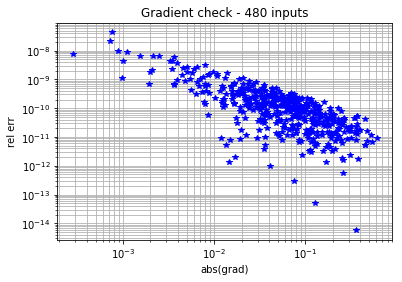

.

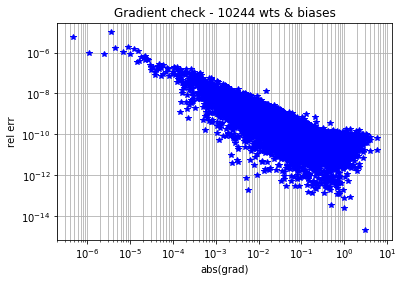

F
FAIL: test_gradient_wt_bias (__main__.TestGradient)
Gradient check on all weights and biases in the network.
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-10-df3fb507f5c7>", line 42, in test_gradient_wt_bias
    self.assertLess(results[0][2],tol)
AssertionError: 9.641852316385773e-06 not less than 1e-07

----------------------------------------------------------------------
Ran 2 tests in 25.064s

FAILED (failures=1)


In [10]:
#MIT License - Copyright (c) 2018 tmatha

class TestGradient(unittest.TestCase):
    """A test case for gradient checking.
    """
    
    def setUp(self):
        """Configure an Lstm network. Set up input vectors, execute a forward prop and a back prop through the network 
        to determine cell states, hidden states and gradients.
        """
        self.verbose=False
        length=3
        ns=[32,16,8]
        nio=[16,32,16,4]
        m=3#batch size
        
        self.net=Network(ns,nio,length)
                
        self.c=[np.random.randn(ns[i],m) for i in range(len(ns))]
        self.h=[np.random.randn(ns[i],m) for i in range(len(ns))]
        self.x=[np.random.randn(nio[0],m) for i in range(length)]
        self.dc=[np.random.randn(ns[i],m) for i in range(len(ns))]
        self.dh=[np.random.randn(ns[i],m) for i in range(len(ns))]
        self.dx=[np.random.randn(nio[-1],m) for i in range(length)]

        _,_,_=self.net.fwd_prop(self.c,self.h,self.x)
        self.dc_,self.dh_,self.dx_=self.net.back_prop(self.dc,self.dh,self.dx)
            
    def test_gradient_wt_bias(self):
        """Gradient check on all weights and biases in the network.
        """
        tol=1e-7
        results=self.gradient_check([item for wt in self.net.wts for item in [wt.W,wt.b]]+
                                    [self.net.wts[-1].Why,self.net.wts[-1].by],
                                    [item for wt in self.net.wts for item in [wt.dW,wt.db]]+
                                   [self.net.wts[-1].dWhy,self.net.wts[-1].dby])
        if self.verbose:
            for result in results:
                print('wt&bias {: e} {: e} {: e}'.format(*result))
        self.__class__.plot([abs(result[0]) for result in results],[result[2] for result in results],
                            'Gradient check - {} wts & biases'.format(len(results)))
        self.assertLess(results[0][2],tol)
        
    def test_gradient_input(self):
        """Gradient check on all inputs to the network.
        """
        tol=1e-7
        results=self.gradient_check(self.c+self.h+self.x,self.dc_+self.dh_+self.dx_)
        if self.verbose:
            for result in results:
                print('input   {: e} {: e} {: e}'.format(*result))
        self.__class__.plot([abs(result[0]) for result in results],[result[2] for result in results],
                            'Gradient check - {} inputs'.format(len(results)))
        self.assertLess(results[0][2],tol)
        
    def gradient_check(self,par,dpar,delta=1e-5):
        """Gradient check on specified parameters.
        """
        results=[]
        for param,dparam in zip(par,dpar):
            self.assertEqual(param.shape,dparam.shape)
            for k in range(param.size):
                old=param.flat[k]
                param.flat[k]=old+delta
                c_plus,h_plus,x_plus=self.net.fwd_prop(self.c,self.h,self.x)
                param.flat[k]=old-delta
                c_minus,h_minus,x_minus=self.net.fwd_prop(self.c,self.h,self.x)
                param.flat[k]=old
                diff=np.concatenate(c_plus+h_plus+x_plus,axis=0)-np.concatenate(c_minus+h_minus+x_minus,axis=0)
                #grad_numeric=np.dot(np.concatenate(self.dc+self.dh+self.dx,axis=0).T,diff).item()/(2*delta)
                grad_numeric=np.dot(np.ravel(np.concatenate(self.dc+self.dh+self.dx,axis=0)),np.ravel(diff))/(2*delta)#**WARNING
                grad_analytic=dparam.flat[k]
                rel_error = abs(grad_analytic-grad_numeric)/abs(grad_numeric+grad_analytic)
                results.append((grad_analytic,grad_numeric,rel_error))                
        return sorted(results,key=lambda result:result[2],reverse=True)
     
    def plot(x,y,title):
        """Plot y=f(x). Static method.
        """
        plt.loglog(x,y,basex=10,basey=10,color='blue',marker='*',linewidth=0)
        plt.grid(True,which='both',axis='both')
        plt.title(title)
        plt.xlabel('abs(grad)')
        plt.ylabel('rel err')
        plt.show()        
                
    def tearDown(self):
        """
        """
        pass

if __name__=='__main__':
    #unittest.main(argv=['first-arg-is-ignored'], exit=False)
    loader=unittest.TestLoader()
    classes=[TestGradient]
    suite=unittest.TestSuite([loader.loadTestsFromTestCase(cls) for cls in classes])
    unittest.TextTestRunner().run(suite)

---
## Training the network on the Penn Tree bank (PTB) dataset
A non-regularized LSTM network, as in [Zaremba et al. (2015)][8], is configured and trained on the [Penn Tree Bank dataset][7]. Training the network for 13 epochs takes about 10 hours in the absence of any GPU acceleration.

[7]: http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz
[8]: https://arxiv.org/abs/1409.2329

INFO:root:['aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett', 'fromstein', 'gitano', 'guterman', 'hydro-quebec']
INFO:root:['consumers', 'may', 'want', 'to', 'move', 'their', 'telephones', 'a', 'little', 'closer']
INFO:root:['no', 'it', 'was', "n't", 'black', 'monday', '<eos>', 'but', 'while', 'the']
INFO:root:size_train 929589, size_valid 73760, size_test 82430
INFO:root:train vocab 10000, valid vocab 6022, test vocab 6049
INFO:root:training: 1 epoch=2323 steps, used=929200 words, unused=389 words
INFO:root:validation: 1 epoch=184 steps, used=73600 words, unused=160 words
INFO:root:test: 1 epoch=206 steps, used=82400 words, unused=30 words


                                TRAINING
time,s    epoch#    step#    epochs         loss               perplexity
                                       train   valid       train         valid
======    ======    =====    ======    =====   =====       =====         =====
0:47:08        0     2322      1.00    5.30    5.26        200.47        192.82
1:33:52        1     2322      2.00    4.91    5.14        135.03        170.94
2:21:18        2     2322      3.00    4.68    5.02        107.52        152.13
3:07:51        3     2322      4.00    4.70    5.05        109.51        156.80
3:53:36        4     2322      5.00    4.34    4.84         76.65        126.85
4:40:46        5     2322      6.00    4.04    4.80         56.72        121.38
5:26:41        6     2322      7.00    3.83    4.80         45.84        121.19
6:12:40        7     2322      8.00    3.70    4.81         40.37        122.38
6:59:15        8     2322      9.00    3.62    4.81         37.45        123.18
7:46:09

INFO:root:test set perplexity after 13.0 epochs - 116.42378985085216
INFO:root:execution time - 10:01:09s


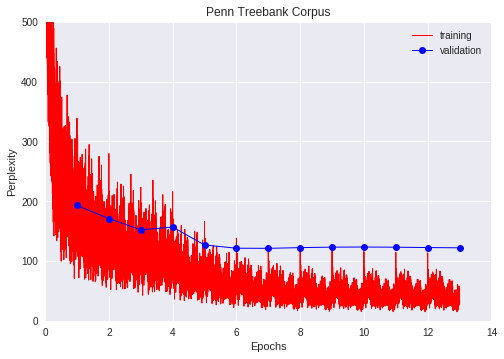

In [15]:
#MIT License - Copyright (c) 2018 tmatha

import logging
import time
import math
import datetime

logging.basicConfig(level=logging.INFO)
start_time=time.time()

def inference_loss(ids,batch_size,length,embedding,cprev,hprev,net):
    """Run inference over an epoch.
    
        Arguments:
        ids -- list or sequence of word id's
        batch_size -- batch size
        length -- length of the unrolled network
        embedding -- word embeddings; numpy array of shape (vocab_size, hidden size)
        cprev -- cell states; list of numpy arrays of shape (hidden size, batch size)
        hprev -- hidden states; list of numpy arrays of shape (hidden size, batch size)
        net -- trained network
        
        Returns:
        loss -- loss per word
    """
    steps=(len(ids)-1)//(batch_size*length)
    use=steps*length*batch_size
    losses=[]
    
    for step in range(steps):
        loss=0
        x_indx=[[i for i in range(step*length+j,use,steps*length)] for j in range(length)]
        x_id=[[ids[i] for i in Lst] for Lst in x_indx]
        x_embed=[np.transpose(embedding.lookup(Lst)) for Lst in x_id]
        
        cprev,hprev,y=net.fwd_prop(cprev,hprev,x_embed)
        yhat=[softmax(z) for z in y]

        for i in range(batch_size):
            for j in range(length):
                y_indx=x_indx[j][i]+1
                loss-=math.log(yhat[j][ids[y_indx],i])
                #yhat[j][ids[y_indx],i]-=1#dy
        losses.append(loss)
    return sum(losses)/use

# ------------------ input data - training, validation & test sets -------------------------------------
with open('ptb.train.txt','r') as f1,open('ptb.valid.txt','r') as f2,open('ptb.test.txt','r') as f3:
    seq_train=f1.read().replace('\n','<eos>').split(' ')
    seq_valid=f2.read().replace('\n','<eos>').split(' ')
    seq_test=f3.read().replace('\n','<eos>').split(' ')
    
seq_train=list(filter(None,seq_train))
seq_valid=list(filter(None,seq_valid))
seq_test=list(filter(None,seq_test))

logging.info(seq_train[:10])
logging.info(seq_valid[:10])
logging.info(seq_test[:10])

size_train=len(seq_train)
size_valid=len(seq_valid)
size_test=len(seq_test)
logging.info('size_train {}, size_valid {}, size_test {}'.format(size_train,size_valid,size_test))

vocab_train=set(seq_train)
vocab_valid=set(seq_valid)
vocab_test=set(seq_test)

assert vocab_valid.issubset(vocab_train)
assert vocab_test.issubset(vocab_train)
size_vocab=len(vocab_train)
logging.info('train vocab {}, valid vocab {}, test vocab {}'.format(len(vocab_train),len(vocab_valid),len(vocab_test)))

vocab_train=sorted(vocab_train)#must have deterministic ordering for word2id dictionary to be reproducible
word2id={w:i for i,w in enumerate(vocab_train)}
id2word={i:w for i,w in enumerate(vocab_train)}

ids_train=[word2id[word] for word in seq_train]
ids_valid=[word2id[word] for word in seq_valid]
ids_test=[word2id[word] for word in seq_test]

# --------------- hyper parameters -----------------------------------
size=200#hidden size
nio=[size,size,size_vocab]
ns=[size]*2
length=20#unrolled length
epochs=13
m=20#batch size
rate=1#learning rate
decay=2#learning rate decay
epochs_no_decay=4
seed=0#random
order=2#norm
max_norm=5#gradient clipping

steps_train=(size_train-1)//(m*length)
steps_valid=(size_valid-1)//(m*length)
steps_test=(size_test-1)//(m*length)

use_train=steps_train*length*m
use_valid=steps_valid*length*m
use_test=steps_test*length*m

logging.info("training: 1 epoch={} steps, used={} words, unused={} words".format(steps_train,use_train,size_train-use_train))
logging.info("validation: 1 epoch={} steps, used={} words, unused={} words".format(steps_valid,use_valid,size_valid-use_valid))
logging.info("test: 1 epoch={} steps, used={} words, unused={} words".format(steps_test,use_test,size_test-use_test))

# ---------------------------------- initialize ---------------------------------------
np.random.seed(seed)
net=Network(ns,nio,length)
cprev_init=[np.zeros((size,m)) for size in ns]
hprev_init=[np.zeros((size,m)) for size in ns]
dcprev=[np.zeros((size,m)) for size in ns]
dhprev=[np.zeros((size,m)) for size in ns]
embedding=Embedding(size_vocab,size)
perplex_train=[]
perplex_valid=[]
verbose=False#True
freq=5

# --------- train for 'epoch' epochs, validate after each epoch, & test at the end -----------------------
print(' '*32+'TRAINING'+'\n'+
      'time,s'+' '*4+
      'epoch#'+' '*4+
      'step#'+' '*4+
      'epochs'+' '*9+
      'loss'+' '*15+
      'perplexity'+'\n'+
      ' '*39+
      'train'+' '*3+
      'valid'+' '*7+
      'train'+' '*9+
      'valid'+'\n'+
      '======'+' '*4+
      '======'+' '*4+
      '====='+' '*4+
      '======'+' '*4+
      '====='+' '*3+
      '====='+' '*7+
      '====='+' '*9+
      '=====')
    
for epoch in range(epochs):
    #train
    cprev=cprev_init
    hprev=hprev_init
    for step in range(steps_train):
        loss=0
        x_indx=[[i for i in range(step*length+j,use_train,steps_train*length)] for j in range(length)]
        x_id=[[ids_train[i] for i in Lst] for Lst in x_indx]
        x_embed=[np.transpose(embedding.lookup(Lst)) for Lst in x_id]
        
        cprev,hprev,y=net.fwd_prop(cprev,hprev,x_embed)
        yhat=[softmax(z) for z in y]

        for i in range(m):
            for j in range(length):
                y_indx=x_indx[j][i]+1
                loss-=math.log(yhat[j][ids_train[y_indx],i])
                yhat[j][ids_train[y_indx],i]-=1#dy
        
        _,_,dx=net.back_prop(dcprev,dhprev,yhat)
        
        norm=np.linalg.norm(np.array([np.linalg.norm(grad,order) for grad in dx]+[net.get_gradient_norm(order)]),order)
        if norm>max_norm:
            shrink=max_norm/norm
            net.shrink_gradient(shrink)
            for grad in dx:
                grad*=shrink
                
        net.update(alpha=rate)
        for i in range(length):
            embedding.update(x_id[i],dx[i],alpha=rate)
            
        loss_avg=loss/(m*length)
        perplexity=math.exp(loss_avg)
        perplex_train.append((epoch+(step+1)/steps_train,perplexity))

        if verbose and step%(steps_train//freq)==0:
            print('{:}'.format(datetime.timedelta(seconds=round(time.time()-start_time))),
                  '{:5n}'.format(epoch),
                  '{:5n}'.format(step),
                  '{:6.2f}'.format(epoch+(step+1)/steps_train),
                  '{:4.2f}'.format(loss_avg),
                  ' -  ',
                  '{:10.2f}'.format(perplexity),
                  '    -',sep=' '*4)
    
    if epoch>=epochs_no_decay-1:
        rate/=decay
        
    #validate
    loss_avg_valid=inference_loss(ids_valid,m,length,embedding,cprev_init,hprev_init,net)
    perplexity_valid=math.exp(loss_avg_valid)
    perplex_valid.append((epoch+(step+1)/steps_train,perplexity_valid))
    print('{:}'.format(datetime.timedelta(seconds=round(time.time()-start_time))),
          '{:5n}'.format(epoch),
          '{:5n}'.format(step),
          '{:6.2f}'.format(epoch+(step+1)/steps_train),
          '{:4.2f}'.format(loss_avg),
          '{:4.2f}'.format(loss_avg_valid),
          '{:10.2f}'.format(perplexity),
          '{:10.2f}'.format(perplexity_valid),sep=' '*4)
        
#test
logging.info("test set perplexity after {} epochs - {}".format(epoch+(step+1)/steps_train,math.exp(inference_loss(ids_test,m,length,embedding,cprev_init,hprev_init,net))))
logging.info("execution time - {}s".format(datetime.timedelta(seconds=round(time.time()-start_time))))

# ----------------------------------- plot ------------------------------------
plt.plot([loss[0] for loss in perplex_train],[loss[1] for loss in perplex_train], linewidth=1,color='red',label='training')
plt.plot([loss[0] for loss in perplex_valid],[loss[1] for loss in perplex_valid], linewidth=1,color='blue',label='validation', marker='o')
plt.grid(True,which='both',axis='both')
plt.title('Penn Treebank Corpus')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.axis([0,14,0,500])
plt.legend()
plt.show()

# ----------------------------------- save -------------------------------------------------------
net.savetxt()
embedding.savetxt('.txt')
def write_list(fname,Lst):
    with open(fname, 'w') as f:
        for e,p in Lst:
            f.write('{:}, {:}'.format(e,p))
write_list('train.txt',perplex_train)
write_list('valid.txt',perplex_valid)   

#---------------------------------- end --------------------------------------------

---
## Final word-level perplexity

The trained network is evaluated by computing its word-level perplexities on the training, validation and test sets. They are compared in Table 1 with those reported in [Zaremba et al. (2015)][8] and [TensorFlow tutorial][9]. The present results are close to those previously reported. The small differences could be due to the random initialization.

[8]: https://arxiv.org/abs/1409.2329
[9]: https://github.com/tensorflow/models/blob/master/tutorials/rnn/ptb/ptb_word_lm.py

In [11]:
#MIT License - Copyright (c) 2018 tmatha

import logging
import time
import math
import datetime

logging.basicConfig(level=logging.INFO)
start_time=time.time()

def inference_loss(ids,batch_size,length,embedding,cprev,hprev,net):
    """Run inference over an epoch.
    
        Arguments:
        ids -- list or sequence of word id's
        batch_size -- batch size
        length -- length of the unrolled network
        embedding -- word embeddings; numpy array of shape (vocab_size, hidden size)
        cprev -- cell states; list of numpy arrays of shape (hidden size, batch size)
        hprev -- hidden states; list of numpy arrays of shape (hidden size, batch size)
        net -- trained network
        
        Returns:
        loss -- loss per word
    """
    steps=(len(ids)-1)//(batch_size*length)
    use=steps*length*batch_size
    losses=[]
    
    for step in range(steps):
        loss=0
        x_indx=[[i for i in range(step*length+j,use,steps*length)] for j in range(length)]
        x_id=[[ids[i] for i in Lst] for Lst in x_indx]
        x_embed=[np.transpose(embedding.lookup(Lst)) for Lst in x_id]
        
        cprev,hprev,y=net.fwd_prop(cprev,hprev,x_embed)
        yhat=[softmax(z) for z in y]

        for i in range(batch_size):
            for j in range(length):
                y_indx=x_indx[j][i]+1
                loss-=math.log(yhat[j][ids[y_indx],i])
                #yhat[j][ids[y_indx],i]-=1#dy
        losses.append(loss)
    return sum(losses)/use

# ------------------ data - training, validation & test set -------------------------------------
with open('ptb.train.txt','r') as f1,open('ptb.valid.txt','r') as f2,open('ptb.test.txt','r') as f3:
    seq_train=f1.read().replace('\n','<eos>').split(' ')
    seq_valid=f2.read().replace('\n','<eos>').split(' ')
    seq_test=f3.read().replace('\n','<eos>').split(' ')
    
seq_train=list(filter(None,seq_train))
seq_valid=list(filter(None,seq_valid))
seq_test=list(filter(None,seq_test))

logging.info(seq_train[:10])
logging.info(seq_valid[:10])
logging.info(seq_test[:10])

size_train=len(seq_train)
size_valid=len(seq_valid)
size_test=len(seq_test)
logging.info('size_train {}, size_valid {}, size_test {}'.format(size_train,size_valid,size_test))

vocab_train=set(seq_train)
vocab_valid=set(seq_valid)
vocab_test=set(seq_test)

assert vocab_valid.issubset(vocab_train)
assert vocab_test.issubset(vocab_train)
size_vocab=len(vocab_train)
logging.info('train vocab {}, valid vocab {}, test vocab {}'.format(len(vocab_train),len(vocab_valid),len(vocab_test)))

vocab_train=sorted(vocab_train)#must have deterministic ordering, so word2id dictionary is reproducible
word2id={w:i for i,w in enumerate(vocab_train)}
id2word={i:w for i,w in enumerate(vocab_train)}

ids_train=[word2id[word] for word in seq_train]
ids_valid=[word2id[word] for word in seq_valid]
ids_test=[word2id[word] for word in seq_test]

# --------------- hyper parameters -----------------------------------
size=200#hidden size
nio=[size,size,size_vocab]
ns=[size]*2
length=1#unrolled length
m=1#batch size

steps_train=(size_train-1)//(m*length)
steps_valid=(size_valid-1)//(m*length)
steps_test=(size_test-1)//(m*length)

use_train=steps_train*length*m
use_valid=steps_valid*length*m
use_test=steps_test*length*m

logging.info("training: 1 epoch={} steps, used={} words, unused={} words".format(steps_train,use_train,size_train-use_train))
logging.info("validation: 1 epoch={} steps, used={} words, unused={} words".format(steps_valid,use_valid,size_valid-use_valid))
logging.info("test: 1 epoch={} steps, used={} words, unused={} words".format(steps_test,use_test,size_test-use_test))

# ---------------------- initialize ---------------------------------------
net=Network(ns,nio,length)
net.loadtxt()
embedding=Embedding(size_vocab,size)
embedding.loadtxt('.txt')
hprev=[np.zeros((size,m)) for size in ns]
cprev=[np.zeros((size,m)) for size in ns]

#---------------- inference ------------------------------------------------------------
perplex_train=math.exp(inference_loss(ids_train,m,length,embedding,cprev,hprev,net))
perplex_valid=math.exp(inference_loss(ids_valid,m,length,embedding,cprev,hprev,net))
perplex_test=math.exp(inference_loss(ids_test,m,length,embedding,cprev,hprev,net))
print('Perplexity of trained LSTM network on PTB training set = {}'.format(perplex_train))
print('Perplexity of trained LSTM network on PTB validation set = {}'.format(perplex_valid))
print('Perplexity of trained LSTM network on PTB test set = {}'.format(perplex_test))


INFO:root:['aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett', 'fromstein', 'gitano', 'guterman', 'hydro-quebec']
INFO:root:['consumers', 'may', 'want', 'to', 'move', 'their', 'telephones', 'a', 'little', 'closer']
INFO:root:['no', 'it', 'was', "n't", 'black', 'monday', '<eos>', 'but', 'while', 'the']
INFO:root:size_train 929589, size_valid 73760, size_test 82430
INFO:root:train vocab 10000, valid vocab 6022, test vocab 6049
INFO:root:training: 1 epoch=929588 steps, used=929588 words, unused=1 words
INFO:root:validation: 1 epoch=73759 steps, used=73759 words, unused=1 words
INFO:root:test: 1 epoch=82429 steps, used=82429 words, unused=1 words


Perplexity of trained LSTM network on PTB training set = 39.66173153000068
Perplexity of trained LSTM network on PTB validation set = 121.71207615129721
Perplexity of trained LSTM network on PTB test set = 116.30045062872492


<center>**Table 1** Final word-level perplexity</center>

   |training set|validation set|test set
---------------------|------------|--------------|---
Present result       | 39.66      | 121.71       | 116.30
Zaremba, et al. (2015)| ?          | 120.7        | 114.5 
TensorFlow tutorial  | 37.99      | 121.39       | 115.91

---
## References
1. S. Hochreiter, and [J. Schmidhuber][1]. Long Short-Term Memory. Neural Computation, 9(8):1735-1780, 1997 
2. Christopher Olah, [Understanding LSTM networks][2], colah's blog, 27 August 2015
3. [Deep learning specialization][3], Taught by Andrew Ng, Kian Katanforoosh, and Younes Bensouda Mourri, Coursera 
4. Fei-Fei Li, Justin Johnson, and Serena Yeung, [Stanford cs231n lecture 10][4], 4 May 2017

5. Klaus Greff, Rupesh Kumar Srivastava, Jan Koutník, Bas R. Steunebrink, and Jürgen Schmidhuber, "[LSTM: A Search Space Odyssey][5]", Transactions on Neural Networks and Learning Systems, 2016 *(Errata: In version 2 of the paper on arXiv, on page 2, the first equation under "B. Backpropagation Through Time" gives the derivative of the loss with respect to yt. In that equation, there should be an over bar over z, i, f and o, denoting gradients inside the non-linear activation functions.)*
6. Andrej Karpathy, [Minimal character-level language model with a Vanilla Recurrent Neural Network, in Python/numpy][6]
 
7. Tomáš Mikolov's web page, [Penn Tree Bank (PTB) dataset][7]

8. Wojciech Zaremba, IlyaSutskever, and Oriol Vinyals, "[Recurrent Neural Network Regularization][8]", ICLR 2015
9. [TensorFlow tutorial][9]
10. Sashank J. Reddi, Satyen Kale, and Sanjiv Kumar, "[On the convergence of Adam and beyond][10]", ICLR 2018 *(Errata: On 'slide 3 Algorithms', 'slide 6 Primary cause for non-convergence', and 'slide 10 AMSGrad' of [Sashank's presentation at ICLR 2018][11], in three places the exponent of beta inside the square root should be t-j instead of t-i. In one place on slide 10 in the AMSGrad update equation, the exponent of beta inside the square root should be k-j instead of k-i. Also, note that 1<=k<=t is implied.)*



[1]: http://people.idsia.ch/~juergen/
[2]: http://colah.github.io/posts/2015-08-Understanding-LSTMs/
[3]: https://www.coursera.org/specializations/deep-learning
[4]: http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture10.pdf
[5]: https://arxiv.org/abs/1503.04069
[6]: https://gist.github.com/karpathy/d4dee566867f8291f086
[7]: http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz
[8]: https://arxiv.org/abs/1409.2329
[9]: https://github.com/tensorflow/models/blob/master/tutorials/rnn/ptb/ptb_word_lm.py
[10]: https://openreview.net/forum?id=ryQu7f-RZ
[11]: https://www.facebook.com/iclr.cc/videos/2123421684353553/
